In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import wandb
import pprint

In [6]:
class MultinomialLogRegression:
    
    def __init__(self,learning_rate,num_epoch):
        self.learning_rate = learning_rate
        self.num_epoch = num_epoch
        self.loss = []
        self.val_acc = []
        self.val_prec = []
        self.val_rec = []
        self.val_f1 = []
        self.train_acc = []
        self.train_prec = []
        self.train_rec = []
        self.train_f1 = []

    def printParameters(self):
        print('---------------------------------------')
        print('Learning Rate  : ',self.learning_rate)
        print('Num Epoches    : ',self.num_epoch)
        print('Num Features   : ',self.num_features)
        print('Num Classes    : ',self.num_classes)
        print('---------------------------------------')
        
    def loadDataFrame(self, df):
        self.df = df
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
    
    def printDatasizes(self):
        print('TrainX : ',self.X_train.shape)
        print('TrainY : ',self.y_train.shape)
        print('TestX  : ',self.X_test.shape)
        print('TestY  : ',self.y_test.shape)
        print('ValX   : ',self.X_val.shape)
        print('ValY   : ',self.y_val.shape)
        
    
    def splitData(self,f):
        X = df.iloc[:, :-1].values
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X = (X - mean) / std
        
        y = df.iloc[:, -1].values
        y = y - 3
        # first splitting the train data
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
        # then splitting the remaining data into val and test (50% each)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        
    
    def softmax(self, x):
        sm = np.exp(x)/np.sum(np.exp(x),axis=0)
        return sm
    
    def Softmax(self,z):
        exp = np.exp(z - np.max(z))
        for i in range(len(z)):
            exp[i]/=np.sum(exp[i])
        return exp
    
    def oneHotEncoding(self, y):
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def crossEntropyLoss(self,y_hat,y):
        epsilon = 1e-10
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        prob = y_hat[np.arange(len(y)), y]
        loss = -np.mean(np.log(prob))
        return loss            
    
    def fit(self):
        X = self.X_train
        y = self.y_train
        y_one_hot = self.oneHotEncoding(y)
        
        self.w = np.random.random((self.num_features,self.num_classes))
        self.b = np.random.random(self.num_classes)
        
        # gradient descent on w and b
        for epoch in range(self.num_epoch):
            y_hat = self.Softmax(X@self.w + self.b)
            del_w = np.dot(X.T,(y_hat-y_one_hot))
            del_b = np.sum(y_hat-y_one_hot)
            
            self.w = self.w - self.learning_rate*del_w
            self.b = self.b - self.learning_rate*del_b
            
            l = self.crossEntropyLoss(y_hat,y)
            self.loss.append(l)
#             wandb.log({"loss": l, "epoch": epoch}) 
            
            
            # storing validation accuracy and loss (and other metrics)
            self.validate()
            
            # storing training accuracy and loss
            y_hat = self.Softmax(self.X_train@self.w + self.b)
            y_pred_train = np.argmax(y_hat,axis=1)
            acc = accuracy_score(self.y_train, y_pred_train)
            precision, recall, f1, _ = precision_recall_fscore_support(self.y_train, y_pred_train, average='weighted', zero_division=1)
            self.train_acc.append(acc)
            self.train_prec.append(precision)
            self.train_rec.append(recall)
            self.train_f1.append(f1)
            
            
#             wandb.log({"Train Accuracy": acc, "epoch": epoch}) 
#             wandb.log({"accuracy": acc, "loss": l})

            print('Epoch : ',epoch,' Loss : ',l)
            
        
    def validate(self):
        y_hat = self.Softmax(self.X_val@self.w + self.b)
        y_pred_val = np.argmax(y_hat,axis=1)
        # uncomment this to print classification report after each validation
        # print(classification_report(self.y_val, y_pred_val,zero_division=1))
    
        acc = accuracy_score(self.y_val, y_pred_val)
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_val, y_pred_val, average='weighted', zero_division=1)

        self.val_acc.append(acc)
        self.val_prec.append(precision)
        self.val_rec.append(recall)
        self.val_f1.append(f1)

    def predict(self):
        y_hat = self.Softmax(self.X_test@self.w + self.b)
        self.y_pred = np.argmax(y_hat,axis=1)
        cr = classification_report(self.y_pred, self.y_test, zero_division=1)
        print(cr)
#         print('Test Accuracy : ',round(accuracy_score(self.y_test, self.y_pred),3))
#         precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, self.y_pred, average='weighted', zero_division=1)
#         print('Precision     : ',round(precision,3))
#         print('Recall        : ',round(recall,3))
#         print('f1 score      : ',round(f1,3))

        

        
        

In [7]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

In [8]:
learning_rate = 0.001
epoches = 100
mlr = MultinomialLogRegression(learning_rate,epoches)
mlr.loadDataFrame(df)
mlr.splitData(0.8)
mlr.printParameters()

---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


## Evaluating the Model on test Dataset

In [9]:
mlr.fit()
print('Test Data Report\n-----------------------------------------------------------')
mlr.predict()

Epoch :  0  Loss :  2.0165900518553026
Epoch :  1  Loss :  1.868820385395094
Epoch :  2  Loss :  1.7717552701833523
Epoch :  3  Loss :  1.7050631259877498
Epoch :  4  Loss :  1.6581313610636672
Epoch :  5  Loss :  1.624563642715396
Epoch :  6  Loss :  1.6001523527672712
Epoch :  7  Loss :  1.5820678803859114
Epoch :  8  Loss :  1.5684045183420565
Epoch :  9  Loss :  1.5578757201189912
Epoch :  10  Loss :  1.5496061057858017
Epoch :  11  Loss :  1.5429927250268187
Epoch :  12  Loss :  1.5376141091512598
Epoch :  13  Loss :  1.5331709898290986
Epoch :  14  Loss :  1.5294475212918128
Epoch :  15  Loss :  1.5262856686281046
Epoch :  16  Loss :  1.5235680688876168
Epoch :  17  Loss :  1.521206393316147
Epoch :  18  Loss :  1.5191333268383105
Epoch :  19  Loss :  1.5172969604581874
Epoch :  20  Loss :  1.5156568170675226
Epoch :  21  Loss :  1.514180998888563
Epoch :  22  Loss :  1.5128441155981196
Epoch :  23  Loss :  1.5116257627181349
Epoch :  24  Loss :  1.5105093924433362
Epoch :  25  L

### Plotting Loss and Accuracy with respect to epoches

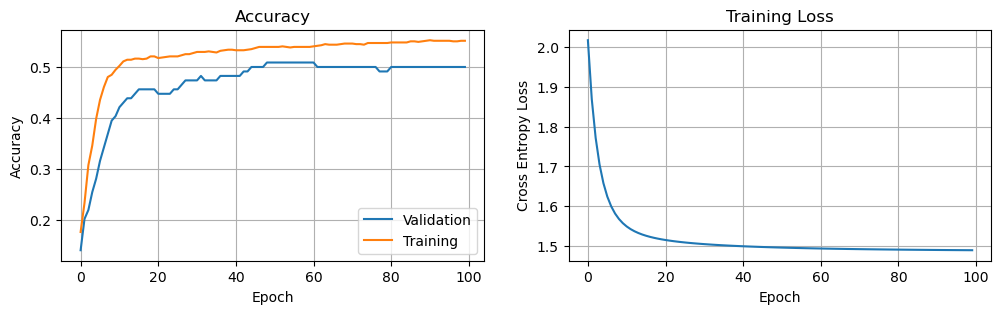

In [10]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(mlr.val_acc,label='Validation')
plt.plot(mlr.train_acc,label='Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlr.loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.grid()

plt.show()


### Plotting Validation Metrics with respect to Epoches

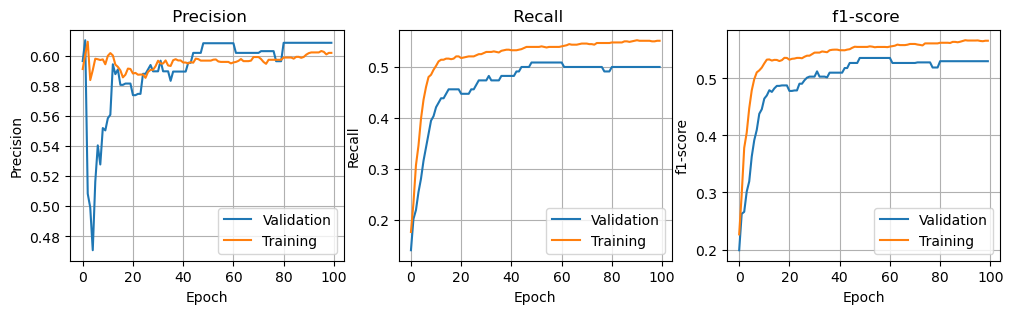

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [11]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(mlr.val_prec,label='Validation')
plt.plot(mlr.train_prec,label='Training')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title(' Precision')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mlr.val_rec,label='Validation')
plt.plot(mlr.train_rec,label='Training')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title(' Recall')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(mlr.val_f1,label='Validation')
plt.plot(mlr.train_f1,label='Training')
plt.xlabel('Epoch')
plt.ylabel('f1-score')
plt.title(' f1-score')
plt.grid()
plt.legend()


plt.show()


## WandB sweep

In [4]:
i = 0
lr_list = [0.001,0.005,0.01,0.02,0.05,0.06,0.08,0.09,0.1,0.2,0.3,0.4,0.5]

for lr in lr_list:
    for ne in range(100,1000,50):
        print(i)
        i = i + 1
        wandb.init(
            # set the wandb project where this run will be logged
            project="Logistic_Regression",

            # track hyperparameters and run metadata
            config={
            'num_epoches' : ne,
            'learning_rate' : lr
            }
        )

        learning_rate = lr
        epoches = ne
        mlr = MultinomialLogRegression(learning_rate,epoches)
        mlr.loadDataFrame(df)
        mlr.splitData(0.8)
        mlr.printParameters()
        mlr.fit()
        wandb.finish()


0


wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


1


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


2


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


3


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


4


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


5


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


6


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


7


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


8


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


9


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


10


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


11


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


12


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


13


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


14


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


15


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


16


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


17


---------------------------------------
Learning Rate  :  0.001
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


18


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


19


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


20


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


21


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


22


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


23


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


24


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


25


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


26


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


27


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


28


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


29


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


30


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


31


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


32


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


33


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


34


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


35


---------------------------------------
Learning Rate  :  0.005
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


36


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


37


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


38


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


39


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


40


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


41


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


42


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


43


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


44


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


45


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


46


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


47


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


48


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


49


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


50


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


51


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


52


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


53


---------------------------------------
Learning Rate  :  0.01
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


54


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


55


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


56


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


57


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


58


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


59


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


60


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


61


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


62


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


63


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


64


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


65


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


66


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


67


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


68


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


69


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


70


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


71


---------------------------------------
Learning Rate  :  0.02
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


72


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


73


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


74


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


75


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


76


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


77


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


78


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


79


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


80


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


81


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


82


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


83


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


84


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


85


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


86


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


87


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


88


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


89


---------------------------------------
Learning Rate  :  0.05
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


90


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


91


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


92


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


93


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


94


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


95


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


96


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


97


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


98


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


99


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


100


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


101


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


102


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


103


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


104


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


105


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


106


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


107


---------------------------------------
Learning Rate  :  0.06
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


108


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


109


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


110


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


111


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


112


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


113


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


114


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


115


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


116


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


117


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


118


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


119


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


120


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


121


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


122


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


123


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


124


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


125


---------------------------------------
Learning Rate  :  0.08
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


126


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


127


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


128


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


129


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


130


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


131


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


132


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


133


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


134


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


135


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


136


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


137


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


138


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


139


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


140


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


141


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


142


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


143


---------------------------------------
Learning Rate  :  0.09
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


144


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


145


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


146


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


147


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


148


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


149


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


150


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


151


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


152


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


153


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


154


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


155


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


156


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


157


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


158


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


159


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


160


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


161


---------------------------------------
Learning Rate  :  0.1
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


162


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


163


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


164


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


165


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


166


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


167


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


168


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


169


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


170


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


171


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


172


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


173


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  650
Num Features   :  11
Num Classes    :  6
---------------------------------------


174


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  700
Num Features   :  11
Num Classes    :  6
---------------------------------------


175


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  750
Num Features   :  11
Num Classes    :  6
---------------------------------------


176


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  800
Num Features   :  11
Num Classes    :  6
---------------------------------------


177


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  850
Num Features   :  11
Num Classes    :  6
---------------------------------------


178


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  900
Num Features   :  11
Num Classes    :  6
---------------------------------------


179


---------------------------------------
Learning Rate  :  0.2
Num Epoches    :  950
Num Features   :  11
Num Classes    :  6
---------------------------------------


180


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  100
Num Features   :  11
Num Classes    :  6
---------------------------------------


/tmp/ipykernel_25836/1453917156.py:59: RuntimeWarning: invalid value encountered in true_divide
  exp[i]/=np.sum(exp[i])
/tmp/ipykernel_25836/1453917156.py:59: RuntimeWarning: invalid value encountered in true_divide
  exp[i]/=np.sum(exp[i])


181


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  150
Num Features   :  11
Num Classes    :  6
---------------------------------------


182


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  200
Num Features   :  11
Num Classes    :  6
---------------------------------------


183


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  250
Num Features   :  11
Num Classes    :  6
---------------------------------------


184


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  300
Num Features   :  11
Num Classes    :  6
---------------------------------------


185


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  350
Num Features   :  11
Num Classes    :  6
---------------------------------------


186


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  400
Num Features   :  11
Num Classes    :  6
---------------------------------------


/tmp/ipykernel_25836/1453917156.py:59: RuntimeWarning: invalid value encountered in true_divide
  exp[i]/=np.sum(exp[i])


187


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  450
Num Features   :  11
Num Classes    :  6
---------------------------------------


/tmp/ipykernel_25836/1453917156.py:59: RuntimeWarning: invalid value encountered in true_divide
  exp[i]/=np.sum(exp[i])
/tmp/ipykernel_25836/1453917156.py:59: RuntimeWarning: invalid value encountered in true_divide
  exp[i]/=np.sum(exp[i])


188


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  500
Num Features   :  11
Num Classes    :  6
---------------------------------------


189


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  550
Num Features   :  11
Num Classes    :  6
---------------------------------------


190


---------------------------------------
Learning Rate  :  0.3
Num Epoches    :  600
Num Features   :  11
Num Classes    :  6
---------------------------------------


191


Problem at: /tmp/ipykernel_25836/1823127122.py 8 <module>


KeyboardInterrupt: 